# Personalized Nutrition Plan Based on DNA!

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load datasets
genetic_data = pd.read_csv("neutral.csv", sep=";")
diet_data = pd.read_csv('Dietary Habits Survey Data.csv')
activity_data = pd.read_csv('dailyActivity_merged.csv')

In [3]:
# Display the first few rows of each dataset
print(genetic_data.head())
print(diet_data.head())
print(activity_data.head())

        Rs_id Contig_Acc_version ContigPositionStart_0_based  \
0       669.0       NT_009714.17                     1992391   
1  79463492.0       NT_009714.17                     2019323   
2  78003756.0        NT_167187.1                     6115827   
3   1799931.0        NT_167187.1                     6116515   
4   1801280.0        NT_167187.1                     6115999   

  ContigPositionEnd_0_based GenomeBuild mRNA_acc_version  \
0                   1992391        37_1      NM_000014.4   
1                   2019323        37_1      NM_000014.4   
2                   6115827        37_1      NM_000015.2   
3                   6116515        37_1      NM_000015.2   
4                   6115999        37_1      NM_000015.2   

   mRNA_start_position_0_based  mRNA_end_position_0_based  \
0                       3110.0                     3110.0   
1                        993.0                      993.0   
2                        275.0                      275.0   
3         

## Step 1: Data Preprocessing 

In [4]:
# Select relevant genetic features for nutrition
genetic_features = genetic_data[['Rs_id', 'MissenseAllele', 'HGNC_Gene_Symbol']]
# Handle missing values
genetic_features.fillna('Unknown', inplace=True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_12192\2918795127.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  genetic_features.fillna('Unknown', inplace=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_12192\2918795127.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genetic_features.fillna('Unknown', inplace=True)


In [5]:
# Rename columns in diet_data for easier processing
diet_data.rename(columns={
    'How many meals do you have a day? (number of regular occasions in a day when a significant and reasonably filling amount of food is eaten)': 'Meals per day',
    'What would best describe your diet:': 'Diet Description',
    'What is your water consumption like (in a day, 1 cup=250ml approx)': 'Water Consumption'
}, inplace=True)

In [6]:
# Select required columns in diet_data
diet_data = diet_data[['Age', 'Gender', 'Meals per day', 'Diet Description', 'Water Consumption']]

In [7]:
# Fill missing values
diet_data.fillna('Unknown', inplace=True)

In [8]:
# One-hot encode 'Diet Description' and label encode 'Gender'
diet_data = pd.get_dummies(diet_data, columns=['Diet Description'])
diet_data['Gender_encoded'] = LabelEncoder().fit_transform(diet_data['Gender'])

## Step 2: Merge and Prepare Data for Machine Learning 

In [9]:
# Merge all datasets (assuming the datasets align row-wise for simplicity)
combined_data = pd.concat([genetic_features, diet_data, activity_data], axis=1)

In [10]:
# Drop unnecessary columns (like text-based genetic columns)
combined_data.drop(columns=['Rs_id', 'HGNC_Gene_Symbol'], inplace=True)

In [11]:
# Handle missing values in 'Meals per day' (target variable)
combined_data = combined_data.dropna(subset=['Meals per day'])

In [12]:
# If 'Meals per day' is categorical, convert to numerical
combined_data['Meals per day'] = pd.to_numeric(combined_data['Meals per day'], errors='coerce')

In [13]:
# Impute missing values in 'Meals per day' with the most frequent value
imputer = SimpleImputer(strategy='most_frequent')
combined_data['Meals per day'] = imputer.fit_transform(combined_data['Meals per day'].values.reshape(-1, 1))

In [14]:
# Split the data into features (X) and target (y)
X = combined_data.drop(columns=['Meals per day'])
y = combined_data['Meals per day']

## Step 3: Encoding and Scaling ###

In [15]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Separate numeric and categorical columns
numeric_columns = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = X_train.select_dtypes(include=['object']).columns

In [17]:
# One-hot encode the categorical columns
onehot_encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
X_train_encoded = onehot_encoder.fit_transform(X_train[categorical_columns])
X_test_encoded = onehot_encoder.transform(X_test[categorical_columns])

In [18]:
# Convert encoded arrays back to DataFrames
X_train_encoded_df = pd.DataFrame(X_train_encoded, index=X_train.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded, index=X_test.index)

In [19]:
# Concatenate the encoded categorical columns with the numeric columns
X_train_combined = pd.concat([X_train[numeric_columns], X_train_encoded_df], axis=1)
X_test_combined = pd.concat([X_test[numeric_columns], X_test_encoded_df], axis=1)

In [20]:
# Ensure all column names are strings
X_train_combined.columns = X_train_combined.columns.astype(str)
X_test_combined.columns = X_test_combined.columns.astype(str)

In [21]:
# Apply StandardScaler to the combined dataset
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_combined)
X_test_scaled = scaler.transform(X_test_combined)

## Step 4: Handle Class Imbalance Using SMOTE ###

In [23]:
from imblearn.over_sampling import SMOTE

In [26]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [27]:
# Check class distribution in y_train
print("Original class distribution:", Counter(y_train))

Original class distribution: Counter({3.0: 40, 4.0: 12, 2.0: 9, 5.0: 1})


In [28]:
# Get the counts of each class in the training data
class_counts = y_train.value_counts()

In [29]:
# Apply SMOTE only to classes with more than 1 sample
minority_classes = class_counts[class_counts > 1].index

In [30]:
# Filter X_train and y_train for only the classes that have more than 1 sample
X_train_filtered = X_train_scaled[y_train.isin(minority_classes)]
y_train_filtered = y_train[y_train.isin(minority_classes)]

In [31]:
# Apply SMOTE to the filtered data
smote = SMOTE(random_state=42, k_neighbors=1)  # k_neighbors=1 for small classes
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_filtered, y_train_filtered)

In [32]:
# Now combine the SMOTE resampled data with the remaining data
remaining_classes = class_counts[class_counts == 1].index
X_train_remaining = X_train_scaled[y_train.isin(remaining_classes)]
y_train_remaining = y_train[y_train.isin(remaining_classes)]

In [33]:
# Concatenate the resampled and the remaining data
X_train_final = np.vstack([X_train_resampled, X_train_remaining])
y_train_final = np.hstack([y_train_resampled, y_train_remaining])

In [34]:
# Train the Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_final, y_train_final)

RandomForestClassifier(random_state=42)

In [35]:
# Predictions and evaluation
y_pred = rf_model.predict(X_test_scaled)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.69
Classification Report:
               precision    recall  f1-score   support

         2.0       0.00      0.00      0.00         1
         3.0       0.69      0.90      0.78        10
         4.0       0.67      0.50      0.57         4
         5.0       0.00      0.00      0.00         1

    accuracy                           0.69        16
   macro avg       0.34      0.35      0.34        16
weighted avg       0.60      0.69      0.63        16



C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


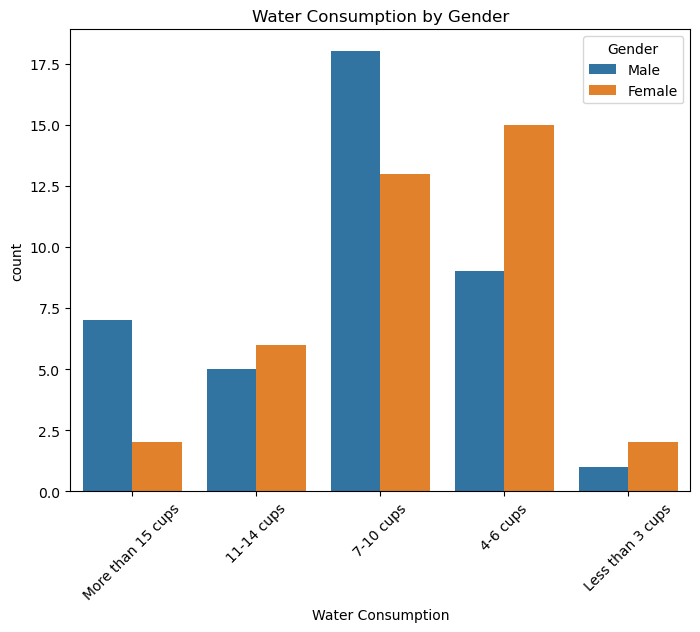

In [42]:
# Countplot for water consumption by gender
plt.figure(figsize=(8, 6))
sns.countplot(x='Water Consumption', hue='Gender', data=diet_data)
plt.title('Water Consumption by Gender')
plt.xticks(rotation=45)
plt.show()

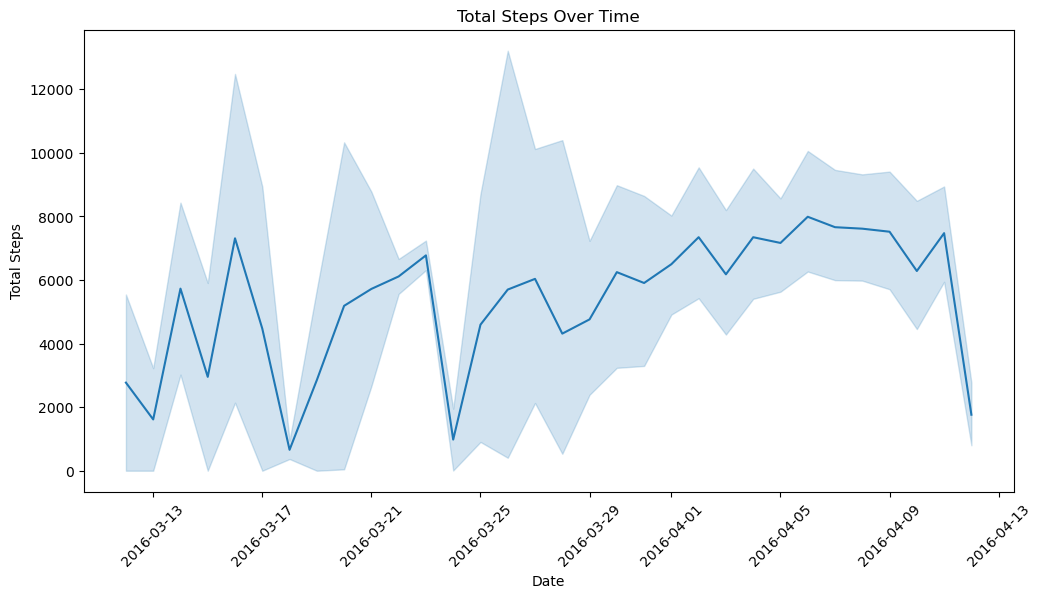

In [43]:
# Line plot of total steps over time
plt.figure(figsize=(12, 6))
activity_data['ActivityDate'] = pd.to_datetime(activity_data['ActivityDate'])
sns.lineplot(x='ActivityDate', y='TotalSteps', data=activity_data)
plt.title('Total Steps Over Time')
plt.xlabel('Date')
plt.ylabel('Total Steps')
plt.xticks(rotation=45)
plt.show()

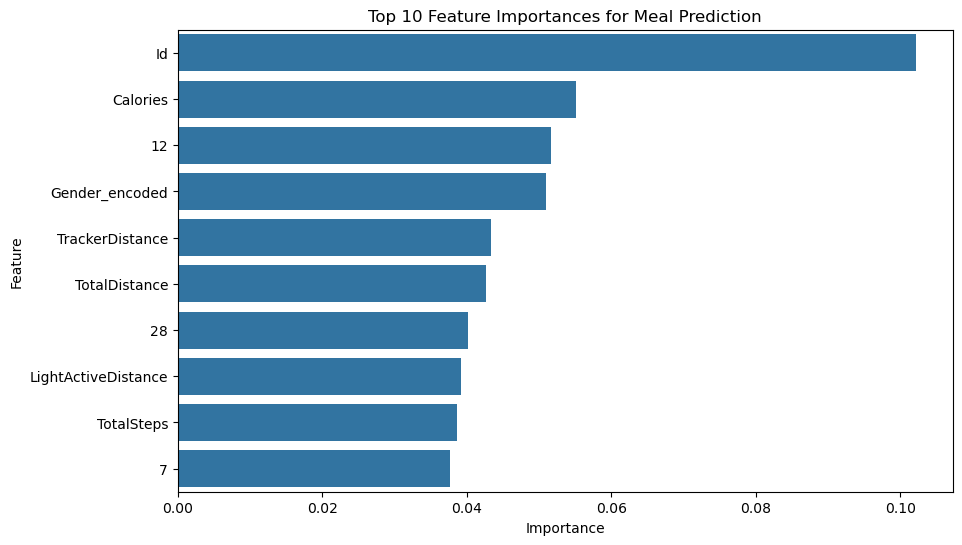

In [44]:
# Feature importance from Random Forest
importances = rf_model.feature_importances_
features = X_train_combined.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the top 10 important features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title('Top 10 Feature Importances for Meal Prediction')
plt.show()

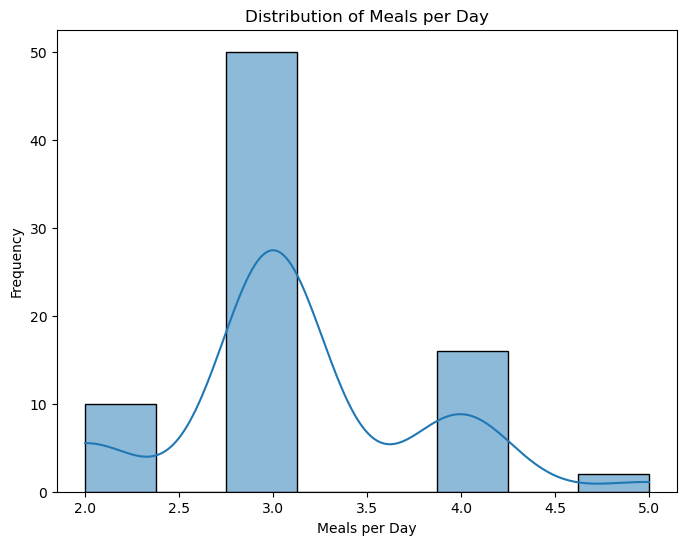

In [45]:
# Histogram of meals per day
plt.figure(figsize=(8, 6))
sns.histplot(combined_data['Meals per day'], kde=True, bins=8)
plt.title('Distribution of Meals per Day')
plt.xlabel('Meals per Day')
plt.ylabel('Frequency')
plt.show()

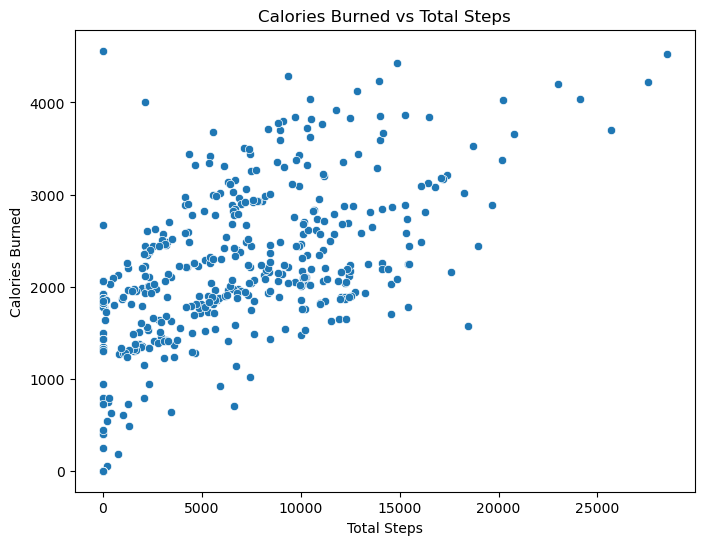

In [46]:
# Scatter plot of calories burned vs. total steps
plt.figure(figsize=(8, 6))
sns.scatterplot(x='TotalSteps', y='Calories', data=activity_data)
plt.title('Calories Burned vs Total Steps')
plt.xlabel('Total Steps')
plt.ylabel('Calories Burned')
plt.show()

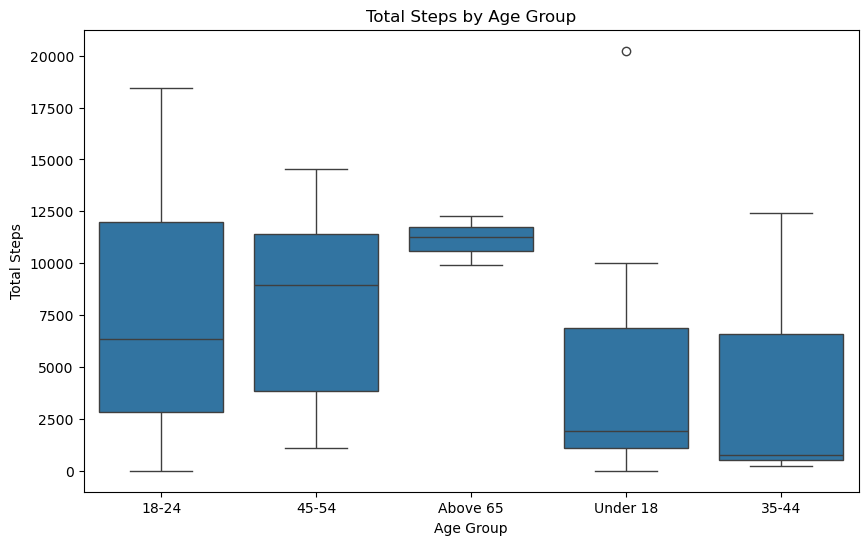

In [47]:
# Group activity data by age and plot activity levels
age_groups = diet_data['Age'].unique()

plt.figure(figsize=(10, 6))
sns.boxplot(x='Age', y='TotalSteps', data=combined_data)
plt.title('Total Steps by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Total Steps')
plt.show()